In [11]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from os.path import join, expanduser, dirname, basename, exists
import pickle

constant_dir = expanduser('~/Documents/temp/src/functions/constants/')

with open(join(constant_dir, 'sensor_heights.pkl'), 'rb') as f:
    sensor_heights = pickle.load(f)

pd.options.plotting.backend = 'holoviews'

In [131]:
data_dir = expanduser('~/Documents/temp/data/snowschool/station/')
df = pd.read_csv(join(data_dir,'winter_20_21_clean.csv'), index_col = 0, parse_dates= ['Unnamed: 0'])
units = df.iloc[0]
df = df.iloc[1:]
df.index = pd.to_datetime(df.index)
df = df.tz_convert('US/Mountain')
air_temp_cols = []
for col in df.columns:
    if 'air_temp' in col:
        air_temp_cols.append(col)
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(e)
df.surface_temp_1 = df.surface_temp_1.interpolate()

could not convert string to float: 'NNW'


## Thermal Diffusivity Equation

$$
\frac{\partial T}{\partial t} = \alpha \frac{\partial^{2} T}{\partial z^{2}}
$$

For time step (1 hour) from 2020-11-13 00:00 to 2020-11-13 01:00 for location AirTemp4

$$
\frac{\partial T}{\partial t} = T_{z = 4, t =1} - T_{z = 4, t = 0} / (t2 - t1)
$$

In [5]:
a4 = test.air_temp_4
dTdt = a4.iloc[1] - a4.iloc[0] / 3600 # seconds in 1 hour
print(f'Change in temp with time @ temparray 4: dT/dt = {dTdt} Deg C / s')

Change in temp with time @ temparray 4: dT/dt = -2.139388888888889 Deg C / s


Finite derivative:
$$
\frac{\partial^{2} T}{\partial z^{2}} = [T_{z = 5, t = 0} - T_{z = 4, t = 0} / (z_{5} - z_{4}) - T_{z = 4, t = 0} - T_{z = 5, t = 0} / (z_{4} - z_{3})] / [z_{4}-z_{3}]
$$

In [10]:
a3 = test.air_temp_3
a4 = test.air_temp_4
a5 = test.air_temp_5
dz = 0.1 # meters
ddTddz = (((a5.iloc[0] - a4.iloc[0]) / (dz)) - ((a4.iloc[0] - a3.iloc[0]) / (dz))) / dz
print(f'Change in the change in temp with distance with distance @ temparray 4 @ t = 0: d2T/dz2 = {ddTddz} Deg C^{2} / m^{2}')

Change in the change in temp with distance with distance @ temparray 4 @ t = 0: d2T/dz2 = 20.000000000000018 Deg C^2 / m^2


$$
\alpha = \frac{\partial T}{\partial t} / \frac{\partial^{2} T}{\partial z^{2}}
$$

In [11]:
alpha = dTdt / ddTddz
print(f'Diffusivity: {alpha}')

Diffusivity: -0.10696944444444435


In [137]:
sum(np.isnan(df.surface_temp_1.values))

0

## Guardrail diffusivities:
Probably between ice @ 2e-07 m2/s and air @ 1.846e-05 m2/s

## From: Evaluation of snowpack temperature formulae (2010)

$$
T (z,t) = \bar{T} + A e^{\frac{z}{d}} \sin (\omega t - \frac{z}{d})
$$

Where $T (z,t)$ is the temperature at some depth and time into the snowpack ($\degree$ C), $\bar{T}$ is the time average temperature at the surface ($\degree$ C), A is the amplitude of the temperature fluctuation at the surface ($\degree$ C), $\omega$ is the angular frequency (0.2618 radians h-1) for diurnal forcing, d is the dampening depth (m) at which the amplitude is 1/e times the surface amplitude. d is related to the thermal diffusivity $d = (\frac{2k}{w})^{0.5}$

In [ ]:
class snowpack_profile():
    def __init__(self):
        pass

    def set_boundary(self, soil_temp, surface_temp):
        self.ground_t = soil_temp
        self.top_t = surface_temp

    def set_snow_temps(self, temp_profile, snow_depth):
        temp_profile = {(height, temp) for (height, temp) in temp_profile if height<snow_depth}
        self.temp_profile = temp_profile

    def calc_diffusivity(self):
        assert hasattr(self, 'temp_profile'), 'Must set temperature profile'
        



In [27]:
df.index = pd.to_datetime(df.index)

In [35]:
df

,net_radiation_1,air_temp_1,air_temp_2,air_temp_3,air_temp_4,air_temp_5,air_temp_6,air_temp_7,air_temp_8,air_temp_9,...,soil_temp_3,soil_temp_4,precip_accum_1,outgoing_radiation_sw_1,outgoing_radiation_lw_1,snow_water_equiv_1,snow_water_equiv_2,incoming_radiation_lw_1,dew_point_temperature_1d,wind_cardinal_direction_1d
2020-10-02 00:00:00+00:00,20.47,20.88,19.47,19.67,19.66,19.86,19.85,19.81,19.89,19.89,...,16.90,18.46,429.514,23.98,407.1,NaN,NaN,243.8,1.26,NNW
2020-10-02 01:00:00+00:00,-107.00,19.52,16.96,17.48,17.64,17.99,18.07,18.03,18.07,18.16,...,15.76,16.00,429.514,14.15,388.0,0.0,0.0,237.8,-4.57,N
2020-10-02 02:00:00+00:00,-141.20,18.71,14.42,15.16,15.44,15.92,16.11,16.16,16.23,16.43,...,14.47,13.74,429.260,5.58,373.3,NaN,NaN,234.4,-6.20,NE
2020-10-02 03:00:00+00:00,-139.50,19.09,14.49,15.29,15.62,16.10,16.28,16.37,16.41,16.58,...,13.23,12.12,429.006,4.36,369.5,NaN,NaN,238.1,-6.74,NE
2020-10-02 04:00:00+00:00,-135.60,19.30,14.17,15.08,15.64,16.23,16.50,16.67,16.71,16.91,...,12.33,11.15,429.006,5.10,366.8,NaN,NaN,239.0,-8.62,ENE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00:00+00:00,657.70,17.78,22.56,21.72,21.25,20.34,20.46,20.12,21.01,20.49,...,9.79,15.61,113.538,219.50,356.9,80.0,80.0,269.4,0.39,WNW
2021-04-30 20:00:00+00:00,671.10,18.55,21.14,20.23,20.10,19.00,19.14,19.09,19.54,19.27,...,12.25,17.74,113.792,246.70,362.4,NaN,NaN,274.7,1.94,NNW
2021-04-30 21:00:00+00:00,603.70,19.60,21.61,20.75,20.83,19.36,19.68,19.76,20.14,19.92,...,13.82,18.87,113.792,243.20,366.8,NaN,NaN,273.5,-0.33,NNW
2021-04-30 22:00:00+00:00,422.40,18.35,20.66,20.17,20.27,19.03,19.42,19.67,19.75,19.79,...,14.90,19.35,113.792,179.10,365.2,NaN,NaN,292.2,1.67,NW


In [36]:
df[pd.to_datetime('2021-01-01').tz_localize('US/Mountain'):pd.to_datetime('2021-02-01').tz_localize('US/Mountain')]

,net_radiation_1,air_temp_1,air_temp_2,air_temp_3,air_temp_4,air_temp_5,air_temp_6,air_temp_7,air_temp_8,air_temp_9,...,soil_temp_3,soil_temp_4,precip_accum_1,outgoing_radiation_sw_1,outgoing_radiation_lw_1,snow_water_equiv_1,snow_water_equiv_2,incoming_radiation_lw_1,dew_point_temperature_1d,wind_cardinal_direction_1d
2021-01-01 07:00:00+00:00,1.64,-3.54,-0.13,-0.50,-0.86,-0.92,-1.55,-1.88,-2.09,-2.26,...,0.44,0.22,313.182,0.90,293.2,NaN,NaN,296.2,-4.39,E
2021-01-01 08:00:00+00:00,2.13,-3.81,-0.11,-0.48,-0.84,-0.89,-1.53,-1.85,-2.05,-2.23,...,0.44,0.23,313.182,0.65,292.9,186.944,178.999,296.1,-4.60,ESE
2021-01-01 09:00:00+00:00,0.52,-3.17,-0.10,-0.47,-0.82,-0.87,-1.50,-1.82,-2.02,-2.21,...,0.44,0.23,313.182,1.34,293.7,NaN,NaN,296.4,-4.95,SSW
2021-01-01 10:00:00+00:00,1.48,-3.41,-0.09,-0.45,-0.80,-0.85,-1.48,-1.79,-2.00,-2.18,...,0.45,0.24,313.182,1.10,293.0,NaN,NaN,296.7,-5.11,N
2021-01-01 11:00:00+00:00,1.64,-3.40,-0.08,-0.44,-0.78,-0.83,-1.45,-1.77,-1.97,-2.16,...,0.45,0.24,313.182,1.00,293.1,NaN,NaN,296.9,-4.95,ESE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01 03:00:00+00:00,-18.69,-0.56,0.06,-0.14,-0.32,-0.36,-0.68,-0.91,-1.02,-1.22,...,0.49,0.31,440.182,0.57,295.2,NaN,NaN,277.2,-6.49,ENE
2021-02-01 04:00:00+00:00,-56.23,-0.17,0.06,-0.14,-0.33,-0.36,-0.68,-0.91,-1.03,-1.23,...,0.48,0.30,439.928,1.21,287.4,NaN,NaN,233.6,-6.84,ENE
2021-02-01 05:00:00+00:00,-6.73,0.17,0.05,-0.15,-0.33,-0.37,-0.69,-0.89,-1.01,-1.22,...,0.49,0.30,439.928,1.02,297.0,NaN,NaN,290.5,-6.32,ENE
2021-02-01 06:00:00+00:00,1.02,0.14,0.04,-0.16,-0.34,-0.38,-0.70,-0.86,-0.99,-1.21,...,0.49,0.29,439.928,0.20,300.8,NaN,NaN,301.5,-6.09,ENE


576

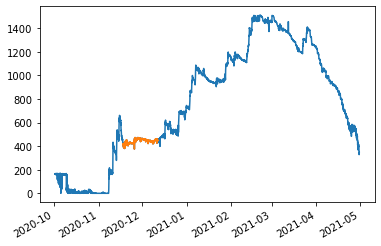

In [138]:
pd.options.plotting.backend = 'matplotlib'
df.snow_depth_1.plot()
sub = df[pd.to_datetime('2020-11-18T00:00').tz_localize('US/Mountain'):pd.to_datetime('2020-12-11T23:00').tz_localize('US/Mountain')]
sub.snow_depth_1.plot()
sub.air_temp_1.size

In [139]:
days = len(sub.resample('D').mean())
hours = len(sub.resample('H').mean())
print(f'Days in subset: {days} or hours: {hours}. So for 24 hours/cycle we are at an k of {hours/24}')
sd = sub.snow_depth_1.mean()/1000
print(f'Average sd: {sd} m')

Days in subset: 24 or hours: 576. So for 24 hours/cycle we are at an k of 24.0
Average sd: 0.44272640972222255 m


## Amplitude Analysis

Recreating Table 1 in Luce and Tarboton

In [121]:
w = 0.2618/3600 # diurnal 0.2618 radians / hour to seconds
z_surf = 0
z_2 = 19/100 # convert cm to m
A_surf = 5.52
A_2 = 0.35
z_d = np.log(A_surf/A_2)
d = z_2 / z_d
k = (d**2)*w/2
print(k)

1.72541211935328e-07


# Doing for this time period

In [140]:
def get_A(arr, freqs = False):
    arr = arr - np.nanmean(arr)
    A = np.abs(fft(arr))
    if freqs:
        f = fftfreq(arr.size, d = 1/24)
        return A, f
    else:
        return A

In [144]:
z_surf = sd - sd
amp_surf, f = get_A(sub.surface_temp_1.values, freqs= True)
idx = np.where(f == 1)[0][0]
amp_surf = amp_surf[idx]
w = 0.2618/3600 # diurnal 0.2618 radians / hour to seconds
res = {}
for col, height in sensor_heights.items():
    if height < sd and height >0:
        amp_z = get_A(sub[col])[idx]
        z = sd - height
        z_d = np.log(amp_surf/ amp_z)
        d = z / z_d
        k = (d**2)*w/2
        res[height] = k

        

In [147]:
res

{0.05: 4.98446825512098e-07,
 0.1: 5.872828327797431e-07,
 0.15: 4.517514076307948e-07,
 0.2: 7.085848007170567e-07,
 0.25: 6.430342821306941e-07,
 0.3: 6.688601595854768e-07,
 0.35: 8.192991747092872e-07,
 0.4: 1.745980397815305e-05}

## Phase Analysis

Recreating Table 1 in Luce and Tarboton

In [152]:
w = 0.2618/3600 # diurnal 0.2618 radians / hour to seconds
z_surf = 0
omega_surf = 4.23
z_2 = 19/100 # convert cm to m
omega_2 = 1.78
z_d = omega_surf - omega_2
d = z_2 / z_d
k = (d**2)*w/2
k

2.1868156786524134e-07

## Now for this subset time period

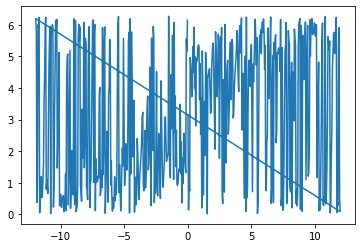

In [67]:
phase = np.angle(fft(sub.air_temp_10))
phase = [p + 2*np.pi if p<0 else p for p in phase]
plt.plot(freqs, phase)

In [153]:
def get_theta(arr, freqs = False):
    arr = arr - np.nanmean(arr)
    phase = np.angle(fft(arr))
    if freqs:
        f = fftfreq(arr.size, d = 1/24)
        return phase, f
    else:
        return phase

In [154]:
z_surf = sd - sd
theta_surf, f = get_theta(sub.surface_temp_1.values, freqs= True)
idx = np.where(f == 1)[0][0]
theta_surf = theta_surf[idx]
w = 0.2618/3600 # diurnal 0.2618 radians / hour to seconds
res = {}
for col, height in sensor_heights.items():
    if height < sd and height > 0:
        theta_z = get_theta(sub[col])[idx]
        z = sd - height
        z_d = theta_surf/ theta_z
        d = z / z_d
        k = (d**2)*w/2
        res[height] = k        

In [155]:
res

{0.05: 3.589711404585378e-08,
 0.1: 6.925672637417527e-10,
 0.15: 7.158744324041911e-09,
 0.2: 1.970072600343656e-07,
 0.25: 3.10897824799064e-07,
 0.3: 2.8128180869394454e-07,
 0.35: 1.9710361028621085e-07,
 0.4: 6.186009760374298e-08}